# Importing Libraries and Dataset

In [ ]:
!pip install optuna
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import optuna
from google.colab import drive
drive.mount('/content/drive')
torch.manual_seed(42) # Seed for reproducibility

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 7.1 MB/s eta 0:00:00
Mounted at /content/drive


# Creating Dataset

In [ ]:
def create_loader(data):
    rainfall_df = pd.read_csv('/content/drive/MyDrive/Thesis_Data/rainfall_df_' + data + '.csv')
    rainfall_df.sort_values(by = ['Date', 'Time'], ascending = [1, 1], inplace = True)
    rainfall_df["datetime"] = pd.to_datetime(rainfall_df["Date"] + ' ' + rainfall_df["Time"], format = '%Y-%m-%d %H:%M:%S')
    rainfall_df.drop(['Date', 'Time'], axis = 1, inplace = True)
    rainfall_df['Rainfall (mm)'] = rainfall_df['Rainfall (mm)'].astype('float')
    rainfall_df.set_index('datetime', inplace=True)
    if data == 'cawang': rainfall_df = rainfall_df[rainfall_df.index > '2018-01-01']
    elif data == 'pasirjaya': rainfall_df.loc['2022-03-02':'2022-04-08','Rainfall (mm)'] = 0 # Contains 6 mm rainfall for a whole month, imputed with 0

    rainfall_df = rainfall_df.reindex(pd.date_range(start = rainfall_df.index.min(), end = rainfall_df.index.max(), freq = 'h')) # Complete the date range for continuity
    rainfall_df.loc[:, 'Rainfall (mm)'] = rainfall_df['Rainfall (mm)'].ffill() # Impute missing data using forward filling

    # Filter out long periods containing 0s (sacrifices continuity)
    if data == 'rancabungur':
        # Define masks
        mask1 = rainfall_df.index < '2021-03-06 14:00:00'
        mask2 = (rainfall_df.index > '2022-09-30 07:00:00') & (rainfall_df.index < '2023-11-15 01:00:00')
        mask3 = (rainfall_df.index > '2024-03-05 17:00:00') & (rainfall_df.index < '2024-03-05 20:00:00')
        mask4 = rainfall_df.index > '2024-09-25 16:00:00'

        # Combine conditions with OR (|)
        combined_mask = mask1 | mask2 | mask3 | mask4

        # Filter the DataFrame
        rainfall_df = rainfall_df.loc[combined_mask]

    elif data == 'pasirjaya':
        # Define masks for the three ranges
        mask1 = rainfall_df.index <= '2019-02-09'
        mask2 = (rainfall_df.index >= '2019-05-01') & (rainfall_df.index <= '2019-06-11')
        mask3 = rainfall_df.index >= '2019-12-09'
        combined_mask = mask1 | mask2 | mask3
        rainfall_df = rainfall_df.loc[combined_mask]

    # Cyclic Features
    rainfall_df.index = pd.DatetimeIndex(rainfall_df.index)
    rainfall_df['year'] = rainfall_df.index.year
    rainfall_df['month'] = rainfall_df.index.month
    rainfall_df['day_of_year'] = rainfall_df.index.dayofyear
    rainfall_df['day'] = rainfall_df.index.day
    rainfall_df['hour'] = rainfall_df.index.hour
    rainfall_df['will_rain'] = (rainfall_df['Rainfall (mm)'] > 0).astype(int)

    # Cyclic Encoding
    for year in pd.unique(rainfall_df['year']):
        doy = rainfall_df[rainfall_df['year'] == year]['day_of_year']
        rainfall_df.loc[rainfall_df['year'] == year, 'doy_sin'] = np.sin(2 * np.pi * doy/doy.max())
        rainfall_df.loc[rainfall_df['year'] == year, 'doy_cos'] = np.cos(2 * np.pi * doy/doy.max())

        for month in pd.unique(rainfall_df['month']):
            day = rainfall_df[(rainfall_df['year'] == year) & (rainfall_df['month'] == month)]['day']
            rainfall_df.loc[(rainfall_df['year'] == year) & (rainfall_df['month'] == month), 'day_sin'] = np.sin(2 * np.pi * day/day.max())
            rainfall_df.loc[(rainfall_df['year'] == year) & (rainfall_df['month'] == month), 'day_cos'] = np.cos(2 * np.pi * day/day.max())

    rainfall_df['month_sin'] = np.sin(2 * np.pi * rainfall_df['month']/rainfall_df['month'].max())
    rainfall_df['month_cos'] = np.cos(2 * np.pi * rainfall_df['month']/rainfall_df['month'].max())
    rainfall_df['hour_sin'] = np.sin(2 * np.pi * rainfall_df['hour']/24)
    rainfall_df['hour_cos'] = np.cos(2 * np.pi * rainfall_df['hour']/24)
    rainfall_df.drop(['month', 'day_of_year', 'day', 'hour', 'year'], axis = 1, inplace = True)

    # Train, validation, and test dataset split
    seq_length = 6 # Using the rainfall from the previous 6 hours to predict the rainfall of the next hour
    lookback = pd.Timedelta(hours = seq_length) # Start validation dataset 6 hours back so that the first prediction starts right after the last training prediction
    if data == 'pasarbaru' or data == 'awsciawi': time = {'start': '2024-01-01', 'end': '2024-07-01'}
    elif data == 'situparigi' or data == 'lengkongbarang': time = {'start': '2024-12-01', 'end': '2025-01-01'}
    elif data == 'rancabungur': time = {'start': '2024-10-01', 'end': '2024-12-01'}
    else: time = {'start': '2023-01-01', 'end': '2024-01-01'}

    train_data = rainfall_df[(rainfall_df.index >= pd.Timestamp('2017-01-01')) & (rainfall_df.index < pd.Timestamp(time['start']))]
    val_data = rainfall_df[(rainfall_df.index >= (pd.Timestamp(time['start']) - lookback)) & (rainfall_df.index < pd.Timestamp(time['end']))]
    test_data = rainfall_df[rainfall_df.index >= (pd.Timestamp(time['end']) - lookback)]

    # Scaling the values to a range of [0,1], useful for LSTM because it requires normalized data
    feature_scaler, target_reg_scaler, target_cls_scaler = MinMaxScaler(), MinMaxScaler(), MinMaxScaler()

    X_train = feature_scaler.fit_transform(train_data)
    y_train_reg = target_reg_scaler.fit_transform(train_data[['Rainfall (mm)']])
    y_train_cls = target_cls_scaler.fit_transform(train_data[['will_rain']])
    X_val = feature_scaler.transform(val_data)
    y_val_reg = target_reg_scaler.transform(val_data[['Rainfall (mm)']])
    y_val_cls = target_cls_scaler.transform(val_data[['will_rain']])
    X_test = feature_scaler.transform(test_data)
    y_test_reg = target_reg_scaler.transform(test_data[['Rainfall (mm)']])
    y_test_cls = target_cls_scaler.transform(test_data[['will_rain']])

    # Create sliding window, LSTM requires sequence input
    def create_sequences(X, y_reg, y_cls, seq_length):
        sequences, reg_labels, cls_labels = [], [], []
        for i in range(len(y_reg) - seq_length):
            sequences.append(X[i:i + seq_length])
            reg_labels.append(y_reg[i + seq_length])
            cls_labels.append(y_cls[i + seq_length])
        return np.array(sequences), np.array(reg_labels), np.array(cls_labels)

    X_train, y_train_reg, y_train_cls = create_sequences(X_train, y_train_reg, y_train_cls, seq_length)
    X_val, y_val_reg, y_val_cls = create_sequences(X_val, y_val_reg, y_val_cls, seq_length)
    X_test, y_test_reg, y_test_cls = create_sequences(X_test, y_test_reg, y_test_cls, seq_length)

    # Convert to PyTorch tensors
    X_train, y_train_reg, y_train_cls = torch.tensor(X_train, dtype = torch.float32), torch.tensor(y_train_reg, dtype = torch.float32), torch.tensor(y_train_cls, dtype = torch.float32)
    X_val, y_val_reg, y_val_cls = torch.tensor(X_val, dtype = torch.float32), torch.tensor(y_val_reg, dtype = torch.float32), torch.tensor(y_val_cls, dtype = torch.float32)
    X_test, y_test_reg, y_test_cls = torch.tensor(X_test, dtype = torch.float32), torch.tensor(y_test_reg, dtype = torch.float32), torch.tensor(y_test_cls, dtype = torch.float32)

    # Load the dataset
    batch_size = 32
    train_loader = DataLoader(TensorDataset(X_train, y_train_reg, y_train_cls), batch_size = batch_size)
    val_loader = DataLoader(TensorDataset(X_val, y_val_reg, y_val_cls), batch_size = batch_size)
    test_loader = DataLoader(TensorDataset(X_test, y_test_reg, y_test_cls), batch_size = batch_size)

    return feature_scaler, target_reg_scaler, target_cls_scaler, rainfall_df, X_train, train_loader, val_loader, test_loader, val_data, test_data, train_data

# Creating the LSTM Model

In [ ]:
# Define the hybrid LSTM model
class RainfallLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True,
            dropout = dropout)
        self.fc_reg = nn.Linear(hidden_size, 1)
        self.fc_cls = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        reg_out = nn.ReLU()(self.fc_reg(hn[-1])) # Regression head
        cls_out = self.fc_cls(hn[-1]) # Classification head

        return cls_out, reg_out

# Custom MSE Loss using weigting by intensity (bigger rainfall gets penalized more heavily)
def safe_reg_loss(pred, target, rain_mask, weight, max_weight):
    """
    Computes MSE loss ONLY for samples where rain_mask is True (i.e., rain is expected).
    Applies custom weighting to these samples.
    """
    # Squeeze to handle potential (batch, 1) shapes to (batch,) for element-wise ops
    pred = pred.squeeze()
    target = target.squeeze()
    rain_mask = rain_mask.squeeze().float() # Ensure mask is float and same shape

    # Select only the predictions and targets corresponding to rainy samples
    rainy_preds = pred[rain_mask == 1]
    rainy_targets = target[rain_mask == 1]

    num_rainy_samples = rainy_targets.numel() # Use .numel() to get the count of elements

    if num_rainy_samples < 1: # Check if there are any rainy samples in the batch
        return torch.tensor(0.0, device=target.device)

    # Calculate max_val only from rainy_targets to ensure meaningful weighting
    max_val = rainy_targets.max()

    if max_val < 1e-6: # If all rainy targets are essentially zero (shouldn't happen much)
        raw_weights = torch.ones_like(rainy_targets)
    else:
        # Apply custom weighting based on the actual rainy targets
        # Clamping ensures weights don't explode for very small values or too large values
        raw_weights = weight + torch.clamp(rainy_targets / max_val, max = max_weight)

    reg_weights = raw_weights / raw_weights.mean() # Normalize weights for the rainy samples

    # Calculate weighted MSE loss only for the rainy samples
    # Use the equivalent of nn.MSELoss(reduction='none') to get element-wise squared errors
    mse_per_sample = (rainy_preds - rainy_targets) ** 2
    weighted_mse_loss = torch.sum(reg_weights * mse_per_sample) / num_rainy_samples # Average over rainy samples

    return weighted_mse_loss

# Define the performance metrics
def perform_reg_metrics(target, output, threshold = None): # Reg metrics are computed using regression output and label
    if threshold is not None: # Only calculate the metrics on rain events/extreme rain events
        if threshold == 0: masking = (target > threshold)
        else: masking = (target >= threshold)
        target = target[masking]
        output = output[masking]
    mse = mean_squared_error(target, output)
    rmse = mse**.5
    mae = mean_absolute_error(target, output)
    r2 = r2_score(target, output)

    return mse, rmse, mae, r2

def perform_cls_metrics(target, output, threshold = None): # Classification metrics are computed using classification output and label
    accuracy = accuracy_score(target, output)
    precision = precision_score(target, output, zero_division = 0)
    recall = recall_score(target, output, zero_division = 0)
    f1 = f1_score(target, output, zero_division = 0)
    confusion = confusion_matrix(target, output)
    tn, fp, fn, tp = confusion.ravel()

    return accuracy, precision, recall, f1, tn, fp, fn, tp

def print_metrics(metrics_cls, metrics_reg, rain_reg, extreme_cls, extreme_reg):
    print(
        f"\tCls Accuracy: {metrics_cls[0]:.4f}, "
        f"Cls Precision: {metrics_cls[1]:.4f}, "
        f"Cls Recall: {metrics_cls[2]:.4f}, "
        f"Cls F1 Score: {metrics_cls[3]:.4f}\n\t"
        f"Reg MSE: {metrics_reg[0]:.4f}, "
        f"Reg RMSE: {metrics_reg[1]:.4f}, "
        f"Reg MAE: {metrics_reg[2]:.4f}, "
        f"Reg R2 Score: {metrics_reg[3]:.4f}\n\t"
        f"Rain MSE: {rain_reg[0]:.4f}, "
        f"Rain RMSE: {rain_reg[1]:.4f}, "
        f"Rain MAE: {rain_reg[2]:.4f}, "
        f"Rain R2 Score: {rain_reg[3]:.4f}\n\t"
        f"Extreme MSE: {extreme_reg[0]:.4f}, "
        f"Extreme RMSE: {extreme_reg[1]:.4f}, "
        f"Extreme MAE: {extreme_reg[2]:.4f}, "
        f"Extreme R2 Score: {extreme_reg[3]:.4f}"
    )

# Save the results of hyperparameter tuning (all trials and the best hyperparameter combination)
def save_tuning(num_trials, fixed_params, hyperparam, metrics, df, name):
    with pd.ExcelWriter(
        '/content/drive/MyDrive/Thesis_Data/pred_sum_' + name + '.xlsx',
        engine = 'openpyxl',
        mode = 'a',
        if_sheet_exists = 'overlay'
    ) as writer:
        pd.DataFrame.from_dict({'num_trials': num_trials, 'epoch': fixed_params['epochs'], 'rain_weight': fixed_params['rain_weight']}, orient = 'index').to_excel(writer, sheet_name = name, index = False, header = False, startrow = 2, startcol = 2)
        pd.DataFrame.from_dict([fixed_params['size_range'], fixed_params['layer_range'], fixed_params['dropout_range'], fixed_params['lr_range']]).to_excel(writer, sheet_name = name, index = False, header = False, startrow = 8, startcol = 2)
        pd.DataFrame.from_dict(hyperparam, orient = 'index').to_excel(writer, sheet_name = name, index = False, header = False, startrow = 8, startcol = 4)
        pd.DataFrame.from_dict(metrics, orient = 'index').to_excel(writer, sheet_name = name, index = False, header = False, startrow = 14, startcol = 2)
        df.to_excel(writer, sheet_name = name + '_tuning', index = False, header = True, startrow = 2, startcol = 1)

# Save training validation logging (loss, metrics)
def save_logging(metrics, rain_metrics, extreme_metrics, name):
    with pd.ExcelWriter(
        '/content/drive/MyDrive/Thesis_Data/pred_sum_' + name + '.xlsx',
        engine = 'openpyxl',
        mode = 'a',
        if_sheet_exists = 'overlay'
    ) as writer:
        pd.DataFrame(metrics).to_excel(writer, sheet_name = name, index = True, header = False, startrow = 10, startcol = 8)
        pd.DataFrame(rain_metrics).to_excel(writer, sheet_name = name, index = False, header = False, startrow = 10, startcol = 26)
        pd.DataFrame(extreme_metrics).to_excel(writer, sheet_name = name, index = False, header = False, startrow = 10, startcol = 31)

# Save validation result (output vs actual)
def save_val(val_cls_targets, val_cls_outputs, val_reg_targets, val_reg_outputs, name):
    with pd.ExcelWriter(
        '/content/drive/MyDrive/Thesis_Data/pred_sum_' + name + '.xlsx',
        engine = 'openpyxl',
        mode = 'a',
        if_sheet_exists = 'overlay'
    ) as writer:
        pd.DataFrame({
        'Val cls target': val_cls_targets.flatten(),
        'Val cls output': val_cls_outputs.flatten(),
        'Val reg target': val_reg_targets.flatten(),
        'Val reg output': val_reg_outputs.flatten()
    }, index = val_data_ori.iloc[6:].index).to_excel(writer, sheet_name = name, index = True, header = False, startrow = 4, startcol = 44)


# Save testing results (metrics, output vs actual)
def save_test(test_cls_targets, test_cls_outputs,test_reg_targets, test_reg_outputs, metrics, rain_metrics, extreme_metrics, name):
    with pd.ExcelWriter(
        '/content/drive/MyDrive/Thesis_Data/pred_sum_' + name + '.xlsx',
        engine = 'openpyxl',
        mode = 'a',
        if_sheet_exists = 'overlay'
    ) as writer:
        pd.DataFrame(metrics).to_excel(writer, sheet_name = name, index = False, header = False, startrow = 4, startcol = 11)
        pd.DataFrame(rain_metrics).to_excel(writer, sheet_name = name, index = False, header = False, startrow = 4, startcol = 26)
        pd.DataFrame(extreme_metrics).to_excel(writer, sheet_name = name, index = False, header = False, startrow = 4, startcol = 31)
        pd.DataFrame({
        'Test cls target': test_cls_targets.flatten(),
        'Test cls output': test_cls_outputs.flatten(),
        'Test reg target': test_reg_targets.flatten(),
        'test reg output': test_reg_outputs.flatten()
    }, index = test_data_ori.iloc[6:].index).to_excel(writer, sheet_name = name, index = True, header = False, startrow = 4, startcol = 49)

# Check if a GPU is available, otherwise use the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameter Tuning

In [ ]:
def objective(trial, size_range, layer_range, dropout_range, lr_range, epochs, rain_weight):
    # Define hyperparameters to tune
    hidden_size = trial.suggest_int('hidden_size', size_range[0], size_range[1])
    num_layers = trial.suggest_int('num_layers', layer_range[0], layer_range[1])
    dropout = trial.suggest_float('dropout', dropout_range[0], dropout_range[1])
    learning_rate = trial.suggest_float('lr', lr_range[0], lr_range[1], log = True)

    # Initialize model
    model = RainfallLSTM(
        input_size = X_train.shape[2],
        hidden_size = hidden_size,
        num_layers = num_layers,
        dropout = dropout
    )
    model.to(device)

    reg_criterion = nn.MSELoss()
    cls_criterion = nn.BCEWithLogitsLoss(reduction = 'none')
    extreme_thresh = 20 # Filtering extreme rainfall to evaluate the metrics
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    model.to(device)

    best_val_loss = float('inf')
    best_metrics = {}

    for epoch in range(epochs + 1):  # Training and validation happens within 1 epoch
        # Training
        model.train()
        train_loss_cls = 0.0
        train_loss_reg = 0.0
        train_loss_total = 0.0
        total_train_samples = 0
        count = 0

        for train_data, train_reg_target, train_cls_target in train_loader:
            train_data, train_reg_target, train_cls_target = train_data.to(device), train_reg_target.to(device), train_cls_target.to(device)
            optimizer.zero_grad()
            train_cls_output, train_reg_output = model(train_data)

            # Weight classification loss by rainy/dry event (rainy hour's loss is amplified to counter data imbalance where dry hours dominate heavily)
            rain_mask = (train_cls_target == 1).float()
            cls_loss = cls_criterion(train_cls_output, train_cls_target)
            cls_loss = (1 + (rain_weight - 1) * rain_mask) * cls_loss
            cls_loss = cls_loss.mean()

            # Weight regression loss by intensity (the bigger the rainfall is, the more the loss is amplified to counter data imbalance)
            # Set a max weight threshold to prevent large errors
            reg_loss = safe_reg_loss(train_reg_output, train_reg_target, rain_mask, 1, 20)

            # No additional weighting for the total loss
            loss = cls_loss + reg_loss
            loss.backward()
            optimizer.step()

            # Accumulate loss per batch
            train_loss_cls += cls_loss.item() * train_data.size(0)
            train_loss_reg += reg_loss.item() * train_data.size(0)
            train_loss_total += loss.item() * train_data.size(0)
            total_train_samples += train_data.size(0)

        # Average the total loss to get the loss per epoch
        train_loss_cls /= total_train_samples
        train_loss_reg /= total_train_samples
        train_loss_total /= total_train_samples

        # Validation
        model.eval()
        val_loss_cls = 0.0
        val_loss_reg = 0.0
        val_loss_total = 0.0
        total_val_samples = 0
        val_reg_outputs = []
        val_reg_targets = []
        val_cls_outputs = []
        val_cls_targets = []

        with torch.no_grad():
            for val_data, val_reg_target, val_cls_target in val_loader:
                val_data, val_reg_target, val_cls_target = val_data.to(device), val_reg_target.to(device), val_cls_target.to(device)
                val_cls_output, val_reg_output = model(val_data)

                # Classification and regression loss in validation aren't weighted to evaluate the true performance
                cls_loss = cls_criterion(val_cls_output, val_cls_target)
                cls_loss = cls_loss.mean()

                # Implement gating mechanism where the regressor is activated when classifier predicts rain, otherwise the rainfall is set to 0
                val_cls_output_prob = torch.sigmoid(val_cls_output.squeeze())
                cls_pred = (val_cls_output_prob > 0.5).float().unsqueeze(1)
                gated_reg_output = val_reg_output * cls_pred
                reg_loss = reg_criterion(gated_reg_output, val_reg_target)
                loss = cls_loss + reg_loss

                val_loss_cls += cls_loss.item() * val_data.size(0)
                val_loss_reg += reg_loss.item() * val_data.size(0)
                val_loss_total += loss.item() * val_data.size(0)
                total_val_samples += val_data.size(0)

                val_cls_outputs.append(val_cls_output)
                val_reg_outputs.append(gated_reg_output)
                val_cls_targets.append(val_cls_target)
                val_reg_targets.append(val_reg_target)

            val_loss_cls /= total_val_samples
            val_loss_reg /= total_val_samples
            val_loss_total /= total_val_samples

        # Transform the data from [0,1] back to normal scale
        val_reg_targets = target_reg_scaler.inverse_transform(torch.cat(val_reg_targets).cpu().numpy().reshape(-1, 1))
        val_reg_outputs = target_reg_scaler.inverse_transform(torch.cat(val_reg_outputs).cpu().numpy().reshape(-1, 1))

        # Convert classification output to binary label
        val_cls_targets = torch.cat(val_cls_targets).cpu().numpy()
        val_cls_outputs = (torch.sigmoid(torch.cat(val_cls_outputs)) >= 0.5).int().cpu().numpy()

        metrics_cls = perform_cls_metrics(val_cls_targets, val_cls_outputs) # Overall classification performance
        metrics_reg = perform_reg_metrics(val_reg_targets, val_reg_outputs) # Overall regression performance
        rain_reg = perform_reg_metrics(val_reg_targets, val_reg_outputs, 0) # Regression performance on predicting rainy events
        extreme_reg = perform_reg_metrics(val_reg_targets, val_reg_outputs, 20) # Regression performance on predicting extreme rain events

        # Save the best epoch's result
        if val_loss_total < best_val_loss:
            best_metrics.update({
                'epoch': epoch,
                'train_loss_total': train_loss_total,
                'train_loss_cls': train_loss_cls,
                'train_loss_reg': train_loss_reg,
                'val_loss_total': val_loss_total,
                'val_loss_cls': val_loss_cls,
                'val_loss_reg': val_loss_reg,
                'Accuracy': metrics_cls[0],
                'Precision': metrics_cls[1],
                'Recall': metrics_cls[2],
                'F1': metrics_cls[3],
                'MSE Reg': metrics_reg[0],
                'RMSE Reg': metrics_reg[1],
                'MAE Reg': metrics_reg[2],
                'R2 Reg': metrics_reg[3],
                'MSE Rain': rain_reg[0],
                'RMSE Rain': rain_reg[1],
                'MAE Rain': rain_reg[2],
                'R2 Rain': rain_reg[3],
                'MSE Extreme': extreme_reg[0],
                'RMSE Extreme': extreme_reg[1],
                'MAE Extreme': extreme_reg[2],
                'R2 Extreme': extreme_reg[3]
            })
            best_val_loss = val_loss_total

        # Report the validation loss and metrics for Optuna
        trial.set_user_attr('Best epoch', best_metrics['epoch'])
        trial.set_user_attr('train_loss_total', best_metrics['train_loss_total'])
        trial.set_user_attr('train_loss_cls', best_metrics['train_loss_cls'])
        trial.set_user_attr('train_loss_reg', best_metrics['train_loss_reg'])
        trial.set_user_attr('val_loss_total', best_metrics['val_loss_total'])
        trial.set_user_attr('val_loss_cls', best_metrics['val_loss_cls'])
        trial.set_user_attr('val_loss_reg', best_metrics['val_loss_reg'])
        trial.set_user_attr('Accuracy', best_metrics['Accuracy'])
        trial.set_user_attr('Precision', best_metrics['Precision'])
        trial.set_user_attr('Recall', best_metrics['Recall'])
        trial.set_user_attr('F1', best_metrics['F1'])
        trial.set_user_attr('MSE Reg', best_metrics['MSE Reg'])
        trial.set_user_attr('RMSE Reg', best_metrics['RMSE Reg'])
        trial.set_user_attr('MAE Reg', best_metrics['MAE Reg'])
        trial.set_user_attr('R2 Reg', best_metrics['R2 Reg'])
        trial.set_user_attr('MSE Rain', best_metrics['MSE Rain'])
        trial.set_user_attr('RMSE Rain', best_metrics['RMSE Rain'])
        trial.set_user_attr('MAE Rain', best_metrics['MAE Rain'])
        trial.set_user_attr('R2 Rain', best_metrics['R2 Rain'])
        trial.set_user_attr('MSE Extreme', best_metrics['MSE Extreme'])
        trial.set_user_attr('RMSE Extreme', best_metrics['RMSE Extreme'])
        trial.set_user_attr('MAE Extreme', best_metrics['MAE Extreme'])
        trial.set_user_attr('R2 Extreme', best_metrics['R2 Extreme'])
        trial.report(best_metrics['val_loss_total'], epoch)

        # Prune the trial if it is not promising
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_val_loss

Import dataset

In [ ]:
# list of names: cawang, awsciawi, situparigi, pamulang, pasarbaru, lengkongbarang, rancabungur, pasirjaya
name = 'pasarbaru' # Change the name to use different dataset
feature_scaler, target_reg_scaler, target_cls_scaler, rainfall_df, X_train, train_loader, val_loader, test_loader, val_data_ori, test_data_ori, train_data_ori = create_loader(name)

In [ ]:
# Optimize Hyperparameters
# Hyperparameters that are being tuned are the number of neurons per layer, number of hidden layers, dropout rate, and learning rate
fixed_params = {'size_range': [16, 64], 'layer_range': [1, 3], 'dropout_range': [0.1, 0.2], 'lr_range': [1e-4, 1e-2], 'epochs': 20, 'rain_weight': 6}
num_trials = 10
storage_path = "sqlite:////content/drive/MyDrive/Thesis_Data/le_study.db"

# Delete existing study to recreate a new one
'''
try:
    storage = optuna.storages.RDBStorage(url=storage_path)
    optuna.delete_study(study_name = name + "_study", storage=storage)
    print("Deleted existing study")
except KeyError:
    print("No existing study")
'''
study = optuna.create_study(
    study_name = name + "_study2",
    direction="minimize",
    storage=storage_path,
    load_if_exists=True
)
remaining_trials = num_trials - len(study.trials)
study.optimize(lambda trial: objective(trial, **fixed_params), n_trials = remaining_trials)

print("Best hyperparameters:", study.best_trial.params)
print("Best validation loss:", study.best_trial.value)
for key, value in study.best_trial.user_attrs.items():
    print(f"Best {key}: {value:.4f}")

[I 2025-06-16 18:28:55,691] Using an existing study with name 'pasarbaru_study2' instead of creating a new one.


Best hyperparameters: {'hidden_size': 46, 'num_layers': 2, 'dropout': 0.1963890383400787, 'lr': 0.0023834289551722516}
Best validation loss: 0.23425729187962774
Best Accuracy: 0.9256
Best Accuracy Extreme: 0.9899
Best Best epoch: 20.0000
Best F1: 0.4992
Best F1 Extreme: 0.1200
Best MAE Extreme: 30.9043
Best MAE Rain: 7.7826
Best MAE Reg: 0.9202
Best MSE Extreme: 1400.1467
Best MSE Rain: 188.5778
Best MSE Reg: 19.2914
Best Precision: 0.5870
Best Precision Extreme: 0.2500
Best R2 Extreme: -2.5905
Best R2 Rain: -0.1858
Best R2 Reg: -0.0655
Best RMSE Extreme: 37.4185
Best RMSE Rain: 13.7324
Best RMSE Reg: 4.3922
Best Recall: 0.4343
Best Recall Extreme: 0.0789
Best train_loss_cls: 0.3471
Best train_loss_reg: 0.0071
Best train_loss_total: 0.3542
Best val_loss_cls: 0.2323
Best val_loss_reg: 0.0019
Best val_loss_total: 0.2343


In [ ]:
# Save hyperparameter tuning results to Excel
all_trials_data = []

for trial in study.trials:
    trial_info = {"trial_number": trial.number}
    trial_info.update(trial.params)      # Optionally include hyperparameters
    trial_info.update(trial.user_attrs)  # Add all user_attr values
    all_trials_data.append(trial_info)

df = pd.DataFrame(all_trials_data)
save_tuning(num_trials, fixed_params, study.best_trial.params, study.best_trial.user_attrs, df, name)

# Training and Validation

In [ ]:
best_params = study.best_params # Use the optimized combination of hyperparameters

# Initialize model
model = RainfallLSTM(
    input_size = X_train.shape[2],
    hidden_size = best_params['hidden_size'],
    num_layers = best_params['num_layers'],
    dropout = best_params['dropout']
)

# Define the loss function and optimizer
reg_criterion = nn.MSELoss()
cls_criterion = nn.BCEWithLogitsLoss(reduction = 'none')
rain_weight = 6
extreme_thresh = 20
optimizer = optim.Adam(model.parameters(), lr = best_params['lr'])
model.to(device)

num_epochs = 100
best_val_loss = float('inf')
all_train_loss = []
all_val_loss = []
metrics, rain_metrics, extreme_metrics = [], [], []

for epoch in range(num_epochs + 1): # Training and validation happens within 1 epoch
    # Training
    model.train() # Put the environment in training mode
    train_loss_cls = 0.0
    train_loss_reg = 0.0
    train_loss_total = 0.0
    total_train_samples = 0
    count = 0
    for train_data, train_reg_target, train_cls_target in train_loader:
        train_data, train_reg_target, train_cls_target = train_data.to(device), train_reg_target.to(device), train_cls_target.to(device)
        optimizer.zero_grad()
        train_cls_output, train_reg_output = model(train_data)
        rain_mask = (train_cls_target == 1).float()  # Mask where 'will_rain' is 1 (rain is expected)
        cls_loss = cls_criterion(train_cls_output, train_cls_target)
        cls_loss = (1 + (rain_weight - 1) * rain_mask)*cls_loss
        cls_loss = cls_loss.mean()
        reg_loss = safe_reg_loss(train_reg_output, train_reg_target, rain_mask, 1, 10)
        loss = cls_loss + reg_loss
        loss.backward()
        optimizer.step()

        # Accumulate loss for logging
        train_loss_cls += cls_loss.item() * train_data.size(0)
        train_loss_reg += reg_loss.item() * train_data.size(0)
        train_loss_total += loss.item() * train_data.size(0)
        total_train_samples += train_data.size(0)

    # Calculate average training loss for the epoch
    train_loss_cls /= total_train_samples
    train_loss_reg /= total_train_samples
    train_loss_total /= total_train_samples

    # Validation
    model.eval() # Put the environment in evaluation mode (for validation and testing)
    val_loss_cls = 0.0
    val_loss_reg = 0.0
    val_loss_total = 0.0
    total_val_samples = 0
    val_reg_outputs = []
    val_reg_targets = []
    val_cls_outputs = []
    val_cls_targets = []

    with torch.no_grad(): # Temporarily disables gradient tracking
        for val_data, val_reg_target, val_cls_target in val_loader:
            val_data, val_reg_target, val_cls_target = val_data.to(device), val_reg_target.to(device), val_cls_target.to(device)
            val_cls_output, val_reg_output = model(val_data)
            rain_mask = (val_cls_target == 1)  # Mask where 'will_rain' is 1 (rain is expected)
            cls_loss = cls_criterion(val_cls_output, val_cls_target)
            cls_loss = cls_loss.mean()
            val_cls_output_prob = torch.sigmoid(val_cls_output.squeeze())  # convert logits to probability
            cls_pred = (val_cls_output_prob > .5).float().unsqueeze(1)
            gated_reg_output = val_reg_output * cls_pred
            reg_loss = reg_criterion(gated_reg_output, val_reg_target)
            loss = cls_loss + reg_loss

            # Accumulate the loss for monitoring
            val_loss_cls += cls_loss.item() * val_data.size(0)
            val_loss_reg += reg_loss.item() * val_data.size(0)
            val_loss_total += loss.item() * val_data.size(0)
            total_val_samples += val_data.size(0)

            # Store outputs for performance metrics
            val_cls_outputs.append(val_cls_output)
            val_reg_outputs.append(gated_reg_output)
            val_cls_targets.append(val_cls_target)
            val_reg_targets.append(val_reg_target)

        # Calculate average validation loss for the epoch
        val_loss_cls /= total_val_samples
        val_loss_reg /= total_val_samples
        val_loss_total /= total_val_samples

    # Inverse transform for regression
    val_reg_targets = target_reg_scaler.inverse_transform(torch.cat(val_reg_targets).cpu().numpy().reshape(-1, 1))
    val_reg_outputs = target_reg_scaler.inverse_transform(torch.cat(val_reg_outputs).cpu().numpy().reshape(-1, 1))

    # Inverse transform for classification (if necessary, e.g., 0 or 1)
    val_cls_targets = torch.cat(val_cls_targets).cpu().numpy()
    val_cls_outputs = (torch.sigmoid(torch.cat(val_cls_outputs)) >= 0.5).int().cpu().numpy()

    # Performance metrics
    metrics_cls = perform_cls_metrics(val_cls_targets, val_cls_outputs)
    metrics_reg = perform_reg_metrics(val_reg_targets, val_reg_outputs)
    rain_reg = perform_reg_metrics(val_reg_targets, val_reg_outputs, 0)
    extreme_reg = perform_reg_metrics(val_reg_targets, val_reg_outputs, 20)
    metrics.append((train_loss_cls, val_loss_cls, train_loss_reg, val_loss_reg) + metrics_reg + metrics_cls)
    rain_metrics.append(rain_reg)
    extreme_metrics.append(extreme_reg)

    all_train_loss.append((train_loss_cls, train_loss_reg))
    all_val_loss.append((val_loss_cls, val_loss_reg))

    if epoch % 20 == 0: # Logging
        print(f"Epoch [{epoch}/{num_epochs}]\n\t"
        f"Train Loss (CLS): {train_loss_cls:.4f}, Train Loss (REG): {train_loss_reg:.4f}, "
        f"Val Loss (CLS): {val_loss_cls:.4f}, Val Loss (REG): {val_loss_reg:.4f}")
        print_metrics(metrics_cls, metrics_reg, rain_reg, extreme_reg)

    if val_loss_total < best_val_loss: # Choose the model with the lowest validation loss for testing
        best_val_loss = val_loss_total
        best_model_state = model.state_dict()

model.load_state_dict(best_model_state)

Epoch [0/100]
	Train Loss (CLS): 0.5605, Train Loss (REG): 0.0077, Val Loss (CLS): 0.3469, Val Loss (REG): 0.0019
	Cls Accuracy: 0.9146, Cls Precision: 0.0000, Cls Recall: 0.0000, Cls F1 Score: 0.0000
	Reg MSE: 18.5277, Reg RMSE: 4.3044, Reg MAE: 0.6500, Reg R2 Score: -0.0233
	Rain MSE: 216.9678, Rain RMSE: 14.7298, Rain MAE: 7.6113, Rain R2 Score: -0.3643
	Extreme Accuracy: 0.9913, Extreme Precision: 0.0000, Extreme Recall: 0.0000, Extreme F1 Score: 0.0000
	Extreme MSE: 1808.0790, Extreme RMSE: 42.5215, Extreme MAE: 37.6579, Extreme R2 Score: -3.6366
Epoch [20/100]
	Train Loss (CLS): 0.3902, Train Loss (REG): 0.0061, Val Loss (CLS): 0.2482, Val Loss (REG): 0.0021
	Cls Accuracy: 0.9160, Cls Precision: 0.5091, Cls Recall: 0.4504, Cls F1 Score: 0.4780
	Reg MSE: 21.3506, Reg RMSE: 4.6207, Reg MAE: 1.0674, Reg R2 Score: -0.1793
	Rain MSE: 195.2330, Rain RMSE: 13.9726, Rain MAE: 8.0330, Rain R2 Score: -0.2276
	Extreme Accuracy: 0.9908, Extreme Precision: 0.0000, Extreme Recall: 0.0000, Extr

<All keys matched successfully>

Save the best model state to be reused in the future

In [ ]:
torch.save(best_model_state, '/content/drive/MyDrive/Thesis_Data/best_' + name + '2.pth')

Save training and validation logging to Excel

In [ ]:
save_logging(metrics, rain_metrics, extreme_metrics, name)

# Loss Curve

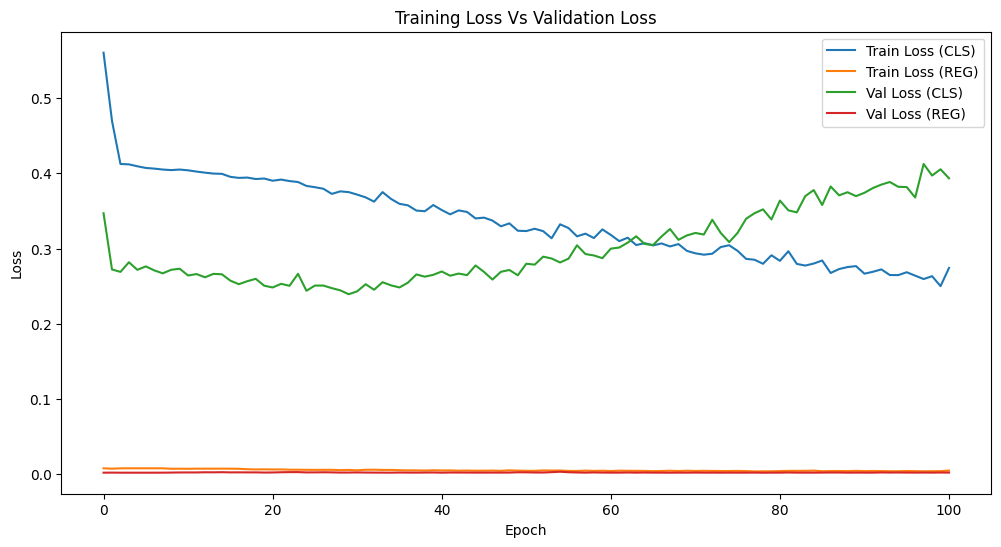

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(range(0, num_epochs + 1), [item[0] for item in all_train_loss], label = 'Train Loss (CLS)')
plt.plot(range(0, num_epochs + 1), [item[1] for item in all_train_loss], label = 'Train Loss (REG)')
plt.plot(range(0, num_epochs + 1), [item[0] for item in all_val_loss], label = 'Val Loss (CLS)')
plt.plot(range(0, num_epochs + 1), [item[1] for item in all_val_loss], label = 'Val Loss (REG)')

plt.title('Training Loss Vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Prediction vs Actual Plot (Validation, Final Epoch)

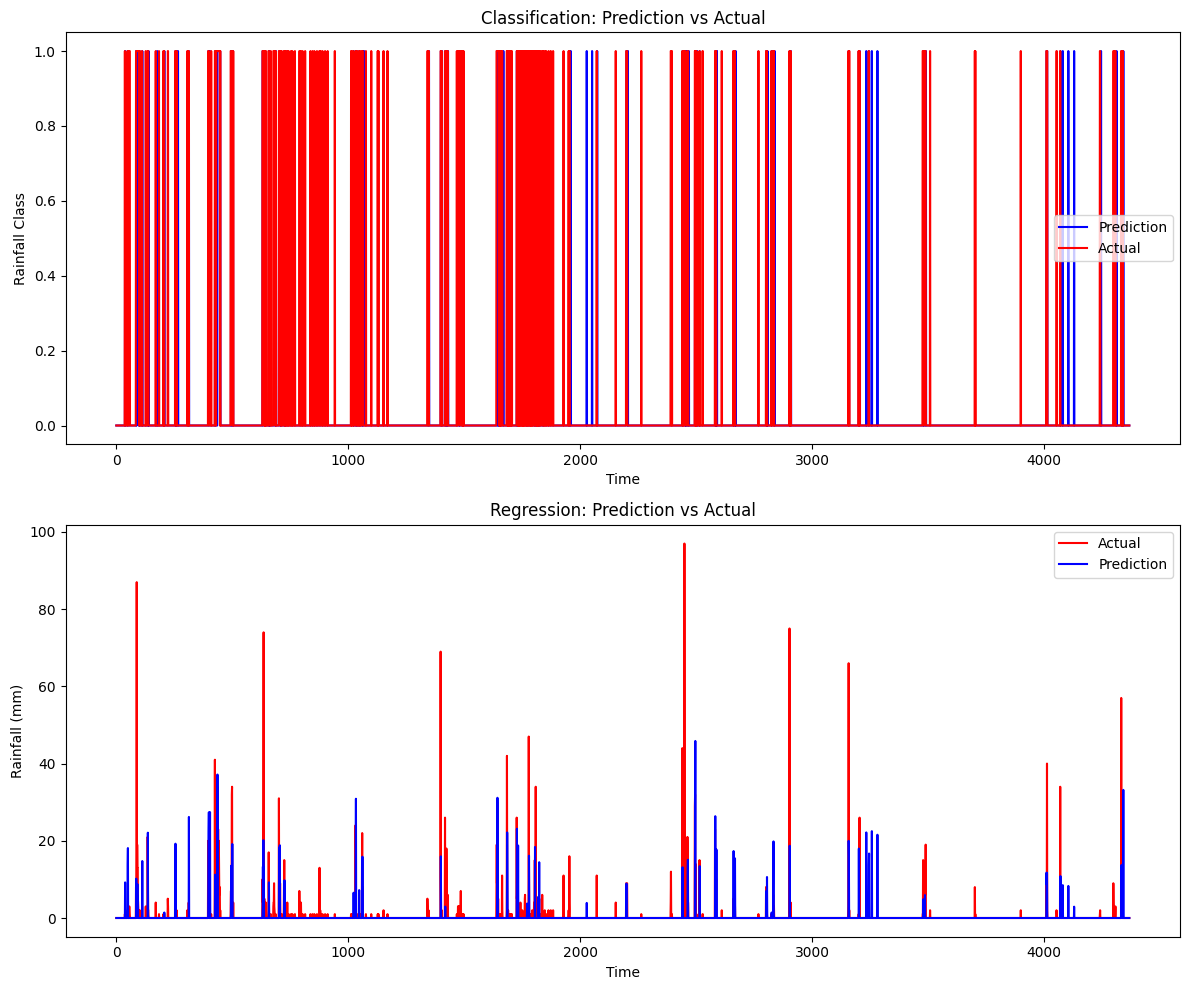

In [ ]:
start_range = 0
end_range = len(val_cls_outputs)
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
val_cls_outputs = (val_cls_outputs > 0.5).astype(int)
axs[0].plot(range(end_range - start_range), val_cls_outputs[start_range:end_range], 'b', label='Prediction')
axs[0].plot(range(end_range - start_range), val_cls_targets[start_range:end_range], 'r', label='Actual')
axs[0].set_title('Classification: Prediction vs Actual')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Rainfall Class')
axs[0].legend()

axs[1].plot(range(end_range - start_range), val_reg_targets[start_range:end_range], 'r', label='Actual')
axs[1].plot(range(end_range - start_range), val_reg_outputs[start_range:end_range], 'b', label='Prediction')
axs[1].set_title('Regression: Prediction vs Actual')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Rainfall (mm)')
axs[1].legend()

plt.tight_layout()
plt.show()

Reload the model state to reproduce best validation result and testing phase

In [ ]:
best_params = study.best_params

model = RainfallLSTM(
    input_size = X_train.shape[2],
    hidden_size = best_params['hidden_size'],
    num_layers = best_params['num_layers'],
    dropout = best_params['dropout']
)

model.load_state_dict(torch.load('/content/drive/MyDrive/Thesis_Data/best_' + name + '2.pth'))

<All keys matched successfully>

# Best Validation Reproduced

In [ ]:
date = []
targets = []
predictions = []
total_val_samples = 0
val_loss_cls = 0
val_loss_reg = 0
val_loss_total = 0
val_reg_outputs = []
val_reg_targets = []
val_cls_outputs = []
val_cls_targets = []
val_metrics = []
val_rain_metrics = []
val_extreme_metrics = []
reg_criterion = nn.MSELoss()
cls_criterion = nn.BCEWithLogitsLoss(reduction = 'none')

model.eval()
with torch.no_grad():
    for val_data, val_reg_target, val_cls_target in val_loader:
        val_data, val_reg_target, val_cls_target = val_data.to(device), val_reg_target.to(device), val_cls_target.to(device)
        val_cls_output, val_reg_output = model(val_data)
        cls_loss = cls_criterion(val_cls_output, val_cls_target)
        rain_mask = (val_cls_target == 1)  # Mask where 'will_rain' is 1 (rain is expected)
        cls_loss = cls_loss.mean()
        val_cls_output_prob = torch.sigmoid(val_cls_output.squeeze())  # convert logits to probability
        cls_pred = (val_cls_output_prob > .5).float().unsqueeze(1)
        gated_reg_output = val_reg_output * cls_pred
        reg_loss = reg_criterion(gated_reg_output, val_reg_target)
        loss = cls_loss + reg_loss

        # Accumulate the loss for monitoring
        val_loss_cls += cls_loss.item() * val_data.size(0)
        val_loss_reg += reg_loss.item() * val_data.size(0)
        val_loss_total += loss.item() * val_data.size(0)
        total_val_samples += val_data.size(0)

        # Store outputs for performance metrics
        val_cls_outputs.append(val_cls_output_prob.unsqueeze(1))
        val_reg_outputs.append(gated_reg_output)
        val_cls_targets.append(val_cls_target)
        val_reg_targets.append(val_reg_target)

    # Calculate average validation loss for the epoch
    val_loss_cls /= total_val_samples
    val_loss_reg /= total_val_samples
    val_loss_total /= total_val_samples

# Inverse transform for regression
val_reg_targets = target_reg_scaler.inverse_transform(torch.cat(val_reg_targets).cpu().numpy().reshape(-1, 1))
val_reg_outputs = target_reg_scaler.inverse_transform(torch.cat(val_reg_outputs).cpu().numpy().reshape(-1, 1))

# Inverse transform for classification (if necessary, e.g., 0 or 1)
val_cls_targets = torch.cat(val_cls_targets).cpu().numpy()
val_cls_outputs = (torch.cat(val_cls_outputs) >= 0.5).int().cpu().numpy()

# Performance metrics
val_metrics_cls = perform_cls_metrics(val_reg_targets, val_reg_outputs)
val_metrics_reg = perform_reg_metrics(val_reg_targets, val_reg_outputs)
val_rain_reg = perform_reg_metrics(val_reg_targets, val_reg_outputs, 0)
val_extreme_cls = perform_cls_metrics(val_reg_targets, val_reg_outputs, 20)
val_extreme_reg = perform_reg_metrics(val_reg_targets, val_reg_outputs, 20)
val_metrics.append((val_loss_cls, val_loss_reg) + val_metrics_reg + val_metrics_cls)
val_rain_metrics.append(val_rain_reg)
val_extreme_metrics.append(val_extreme_reg)
save_val(val_cls_targets, val_cls_outputs,val_reg_targets, val_reg_outputs, val_metrics, val_rain_metrics, val_extreme_metrics, name)

Save the validation results from the best epoch

In [ ]:
save_val(val_cls_targets, val_cls_outputs, val_reg_targets, val_reg_outputs, metrics, rain_metrics, extreme_metrics, name)

# Prediction vs Actual (Best Epoch)

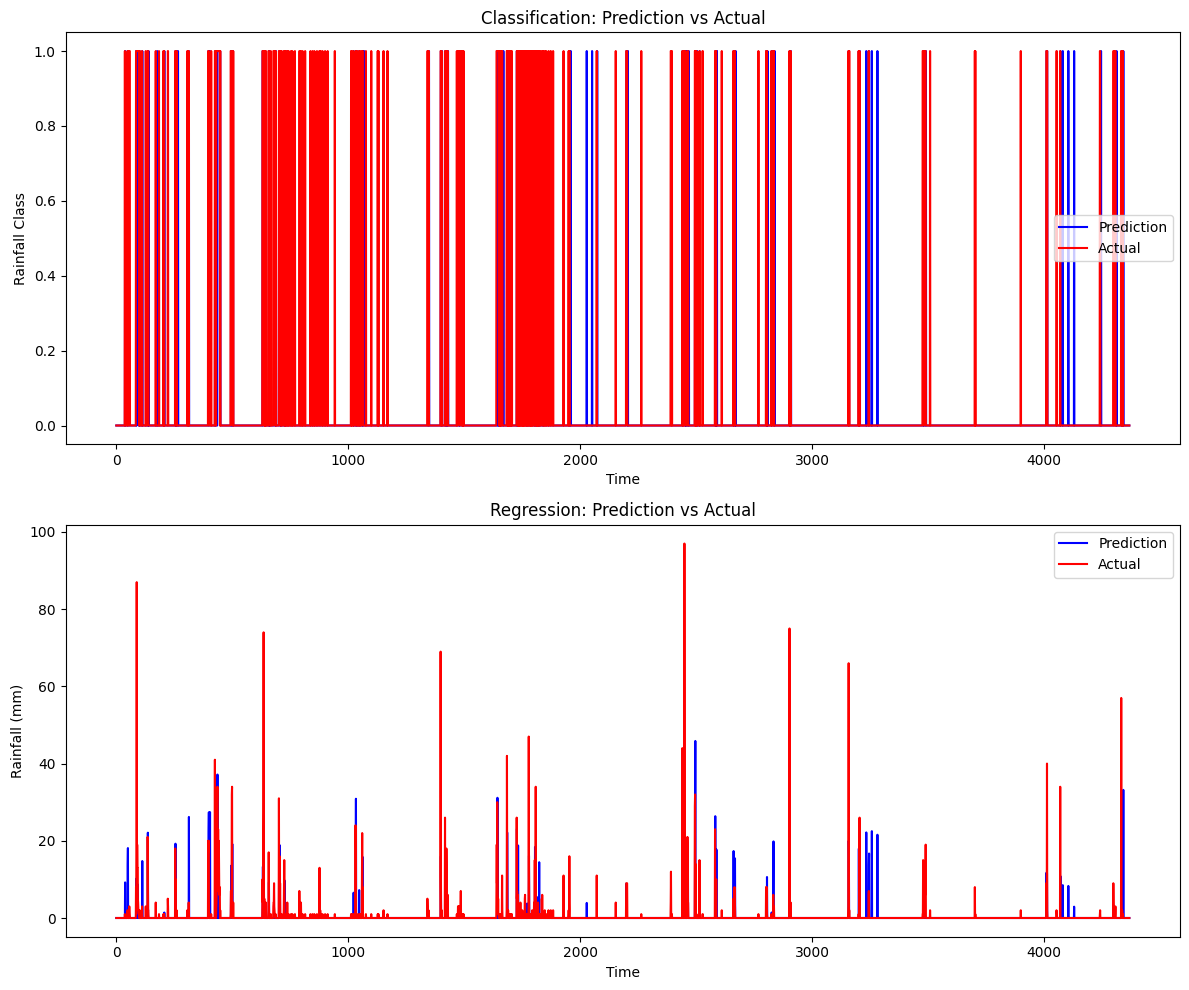

In [ ]:
start_range = 0
end_range = len(val_cls_outputs)
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
val_cls_outputs = (val_cls_outputs > 0.5).astype(int)
axs[0].plot(range(end_range - start_range), val_cls_outputs[start_range:end_range], 'b', label='Prediction')
axs[0].plot(range(end_range - start_range), val_cls_targets[start_range:end_range], 'r', label='Actual')
axs[0].set_title('Classification: Prediction vs Actual')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Rainfall Class')
axs[0].legend()

axs[1].plot(range(end_range - start_range), val_reg_outputs[start_range:end_range], 'b', label='Prediction')
axs[1].plot(range(end_range - start_range), val_reg_targets[start_range:end_range], 'r', label='Actual')
axs[1].set_title('Regression: Prediction vs Actual')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Rainfall (mm)')
axs[1].legend()

plt.tight_layout()
plt.show()

# Testing

In [ ]:
# Testing set evaluation
date = []
targets = []
predictions = []
total_test_samples = 0
test_loss_cls = 0
test_loss_reg = 0
test_loss_total = 0
test_reg_outputs = []
test_reg_targets = []
test_cls_outputs = []
test_cls_targets = []
test_metrics = []
test_rain_metrics = []
test_extreme_metrics = []

model.eval()
with torch.no_grad():
    for test_data, test_reg_target, test_cls_target in test_loader:
        test_data, test_reg_target, test_cls_target = test_data.to(device), test_reg_target.to(device), test_cls_target.to(device)
        test_cls_output, test_reg_output = model(test_data)
        cls_loss = cls_criterion(test_cls_output, test_cls_target)
        rain_mask = (test_cls_target == 1)  # Mask where 'will_rain' is 1 (rain is expected)
        cls_loss = cls_loss.mean()
        test_cls_output_prob = torch.sigmoid(test_cls_output.squeeze())  # convert logits to probability
        cls_pred = (test_cls_output_prob > .5).float().unsqueeze(1)
        gated_reg_output = test_reg_output * cls_pred
        reg_loss = reg_criterion(gated_reg_output, test_reg_target)
        loss = cls_loss + reg_loss

        # Accumulate the loss for monitoring
        test_loss_cls += cls_loss.item() * test_data.size(0)
        test_loss_reg += reg_loss.item() * test_data.size(0)
        test_loss_total += loss.item() * test_data.size(0)
        total_test_samples += test_data.size(0)

        # Store outputs for performance metrics
        test_cls_outputs.append(test_cls_output_prob.unsqueeze(1))
        test_reg_outputs.append(gated_reg_output)
        test_cls_targets.append(test_cls_target)
        test_reg_targets.append(test_reg_target)

    # Calculate average validation loss for the epoch
    test_loss_cls /= total_test_samples
    test_loss_reg /= total_test_samples
    test_loss_total /= total_test_samples

# Inverse transform for regression
test_reg_targets = target_reg_scaler.inverse_transform(torch.cat(test_reg_targets).cpu().numpy().reshape(-1, 1))
test_reg_outputs = target_reg_scaler.inverse_transform(torch.cat(test_reg_outputs).cpu().numpy().reshape(-1, 1))

# Inverse transform for classification (if necessary, e.g., 0 or 1)
test_cls_targets = torch.cat(test_cls_targets).cpu().numpy()
test_cls_outputs = (torch.cat(test_cls_outputs) >= 0.5).int().cpu().numpy()

# Performance metrics
test_metrics_cls = perform_cls_metrics(test_reg_targets, test_reg_outputs)
test_metrics_reg = perform_reg_metrics(test_reg_targets, test_reg_outputs)
test_rain_reg = perform_reg_metrics(test_reg_targets, test_reg_outputs, 0)
test_extreme_reg = perform_reg_metrics(test_reg_targets, test_reg_outputs, 20)
test_metrics.append((test_loss_cls, test_loss_reg) + test_metrics_reg + test_metrics_cls)
test_rain_metrics.append(test_rain_reg)
test_extreme_metrics.append(test_extreme_reg)

Save testing result to Excel

In [ ]:
save_test(test_cls_targets, test_cls_outputs,test_reg_targets, test_reg_outputs, test_metrics, test_rain_metrics, test_extreme_metrics, name)

# Prediction vs Actual (Testing)

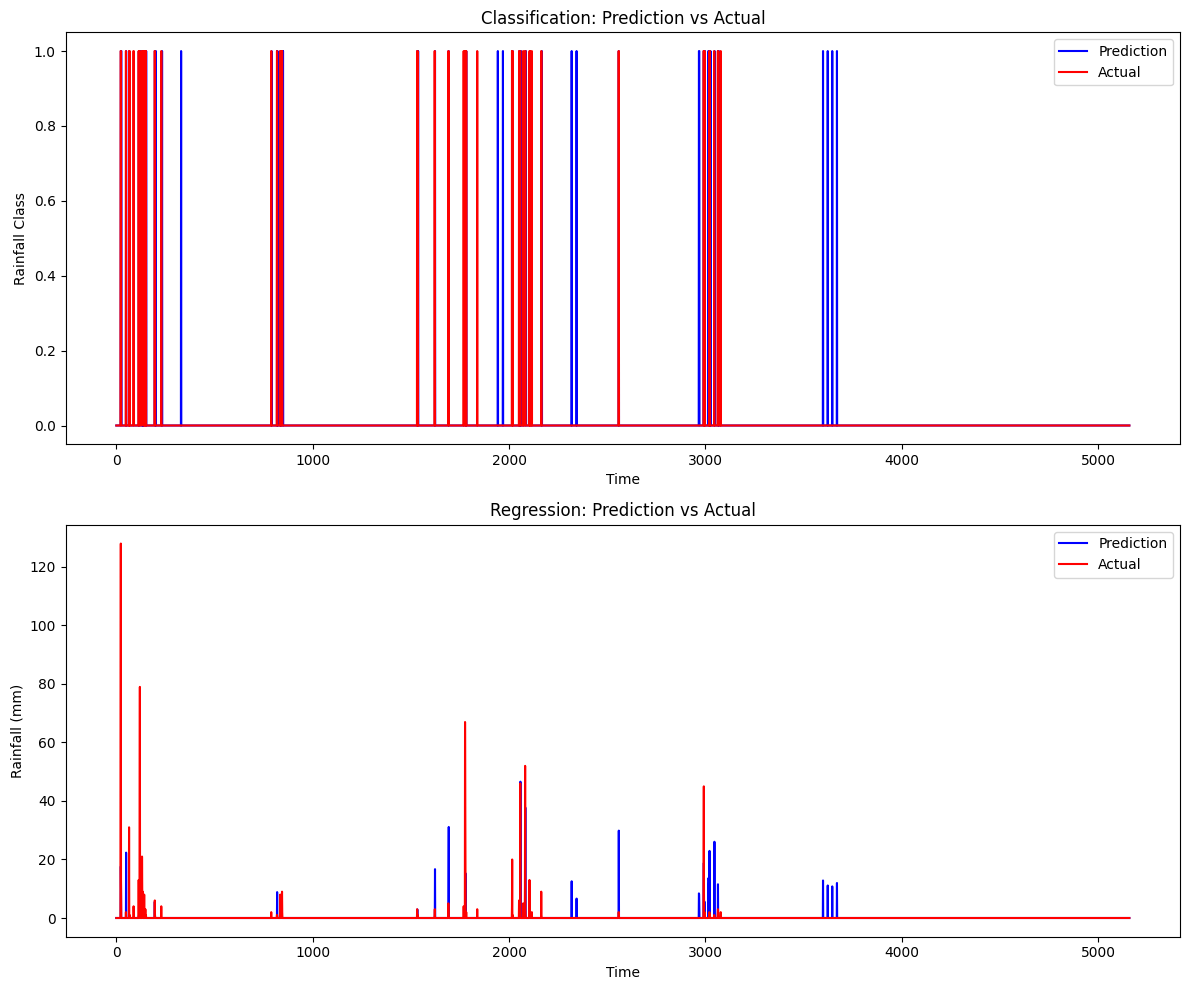

In [ ]:
start_range = 0
end_range = len(test_cls_outputs)
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
val_cls_outputs = (val_cls_outputs > 0.5).astype(int)
axs[0].plot(range(end_range - start_range), test_cls_outputs[start_range:end_range], 'b', label='Prediction')
axs[0].plot(range(end_range - start_range), test_cls_targets[start_range:end_range], 'r', label='Actual')
axs[0].set_title('Classification: Prediction vs Actual')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Rainfall Class')
axs[0].legend()

axs[1].plot(range(end_range - start_range), test_reg_outputs[start_range:end_range], 'b', label='Prediction')
axs[1].plot(range(end_range - start_range), test_reg_targets[start_range:end_range], 'r', label='Actual')
axs[1].set_title('Regression: Prediction vs Actual')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Rainfall (mm)')
axs[1].legend()

plt.tight_layout()
plt.show()

# Training-Validation-Testing Dataset Split Visualization

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

for i in name = ['cawang', 'awsciawi', 'situparigi', 'pamulang', 'pasarbaru', 'lengkongbarang', 'rancabungur', 'pasirjaya']:
    _, _, _, _, _, _, _, _, val_data_ori, test_data_ori, train_data_ori = create_loader(i)
    plt.figure(figsize = (12,5))
    if i == 'rancabungur' or i == 'pasirjaya':
        plt.plot(range(len(train_data_ori)), train_data_ori['Rainfall (mm)'], label = 'Training')
        plt.plot(range(len(train_data_ori), len(train_data_ori) + len(val_data_ori)), val_data_ori['Rainfall (mm)'], label = 'Validation')
        plt.plot(range(len(train_data_ori) + len(val_data_ori), len(train_data_ori) + len(val_data_ori) + len(test_data_ori)), test_data_ori['Rainfall (mm)'], label = 'Testing')
        plt.xlabel('Time step')
    else:
        plt.plot(train_data_ori.index, train_data_ori['Rainfall (mm)'], label = 'Training')
        plt.plot(val_data_ori.index, val_data_ori['Rainfall (mm)'], label = 'Validation')
        plt.plot(test_data_ori.index, test_data_ori['Rainfall (mm)'], label = 'Testing')
        plt.xlabel('Date')

    plt.ylabel('Rainfall (mm)')
    plt.legend()

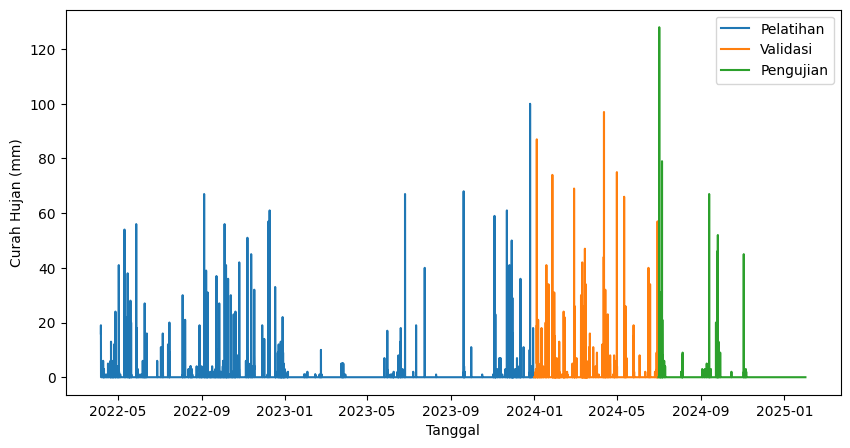

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(train_data_ori.index, train_data_ori['Rainfall (mm)'], label = 'Training')
plt.plot(val_data_ori.index, val_data_ori['Rainfall (mm)'], label = 'Validation')
plt.plot(test_data_ori.index, test_data_ori['Rainfall (mm)'], label = 'Testing')
plt.ylabel('Rainfall (mm)')
plt.xlabel('Date')
plt.legend()